In [1]:
from matplotlib import pyplot as plt
import errno

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os

import threading

In [2]:
def plot_cwnd_vs_time_individual(noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr"):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    for i in range(noOfSources):
        cwndvstime = {}

        with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        plt.plot(cwndvstime.keys(), cwndvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("cwnd")
    plt.title(f"Congestion windows size vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()
     
def plot_cwnd_vs_time(noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr"):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    source_cwnd = {}
    
    for i in range(noOfSources):
        cwndvstime = {}

        with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        source_cwnd[i] = cwndvstime; 
    
    start_time = int(list(source_cwnd[0].keys())[0])
    
    cwnd_vs_time_avg = {}
    
    for t in range(start_time, start_time+len(source_cwnd[0])):
        cwnd_vs_time_avg[t] = 0;
        for i in range(noOfSources):
            cwnd_vs_time_avg[t] += source_cwnd[i][t];
        cwnd_vs_time_avg[t] = cwnd_vs_time_avg[t] / noOfSources;
    
    plt.plot(cwnd_vs_time_avg.keys(), cwnd_vs_time_avg.values() );
    
    
    
    plt.xlabel("time")
    plt.ylabel("avg cwnd")
    plt.title(f"Average Congestion windows size vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()
    
def plot_dropped_vs_time( noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr"):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/droppedPacketTrace.txt", "r") as f:
        lines = f.readlines()
        prev = 0
        
        for line in lines:
            split_line = line.split()
            droppedpvstime[split_line[0]] = int(split_line[1])-prev;
            prev = int(split_line[1])

    
    plt.plot(droppedpvstime.keys(), droppedpvstime.values())
    
    plt.xlabel("time")
    plt.ylabel("Packet Dropped")
    plt.title(f"Packet Dropped vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()

def plot_link_utilization_vs_time( noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr", maxQSize = "2084p", bottleneck_bandwidth = 100 , packetSize = 1458):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    linkutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/bottleneckTx.txt", "r") as f:
        lines = f.readlines()
        
    prev_packetsTx = 0;
    
    for line in lines:
        split_line = line.split()
        linkutilvstime[float(split_line[0])] = 100 * ((float(split_line[1])-float(prev_packetsTx))*packetSize)/((bottleneck_bandwidth/8)*1024*1024);
        prev_packetsTx = split_line[1];

    
    
    plt.plot(linkutilvstime.keys(), linkutilvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("Link utilization %")
    plt.title(f"Link utilization vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()

def plot_qsize_vs_time( noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr", maxQSize = "2084p"):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/qsizeTrace.txt", "r") as f:
        lines = f.readlines()
    
    for line in lines:
        split_line = line.split()
        
        qutilvstime[float(split_line[0])] = float(split_line[1]);

    
    plt.plot(qutilvstime.keys(), qutilvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("Q utilization (abs)")
    plt.title(f"Q utilization vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()

def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTT = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTT));
    

In [3]:
def main(flavour = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth = 100, 
         bottleneck_delay = 1 , RTT = "10ms", packetSize = 1458, queueL = "5p", noOfSource = 2, 
         rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0, SRBuffers = "off"):
     
     if queueL[-3:] == "BDP":
          queueL = ((float(bottleneck_bandwidth[0:-4]) * (10**6) * float(bottleneck_delay[0:-2]) * 10**(-3))/8)/packetSize
          queueL = str(queueL)+'p'
     
     print ( queueL )
     
     # access_link_delay_val = RTT[0:-2]
     access_link_bandwidth_val = total_access_bandwidth[0:-4]
     
     #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
     access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
     
     lock = threading.Lock();
     
     
     lock.acquire();   
     # Creating new directory structure to isolate 2 different processes and their output
     try: 
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}/{noOfSource}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}/{noOfSource}")
     except OSError as exc:
          if exc.errno != errno.EEXIST:
               raise
          pass
     
     lock.release();
    
     # if os.path.exists("/mnt/Store/Project-summer/runtime"):
     #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")
          
     cmd = f'''./ns3 run \"scratch/tcp_ftp_n --nSources={noOfSource} 
     --flavour={flavour} --bottleneckBandwidth={bottleneck_bandwidth} 
     --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
     --queueSize={queueL} --pktSize={packetSize} 
     --simDuration={time} --enableBottleneckTrace={enableBottleneckTrace} 
     --RTT={RTT}\"'''
     
     #--command-template=\"gdb --args %s <args>\"
     
     #print(cmd)
     os.system(cmd)
     plot_cwnd_vs_time(noOfSource, RTT, flavour)
     plot_cwnd_vs_time_individual(noOfSource, RTT, flavour)
     plot_qsize_vs_time(noOfSource, RTT, flavour, queueL)
     plot_dropped_vs_time(noOfSource, RTT, flavour)
     #plot_link_utilization_vs_time(noOfSource, RTT, flavour, bottleneck_bandwidth, packetSize)
     

93.28358208955224p
[0/2] Re-checking globbed directories...
ninja: no work to do.
  Tx bytes = 120474176
  Rx bytes = 120435368
  Throughput = 9.6268 Mbps.
  Tx bytes = 5354696
  Rx bytes = 5354696
  Throughput = 0.424134 Mbps.


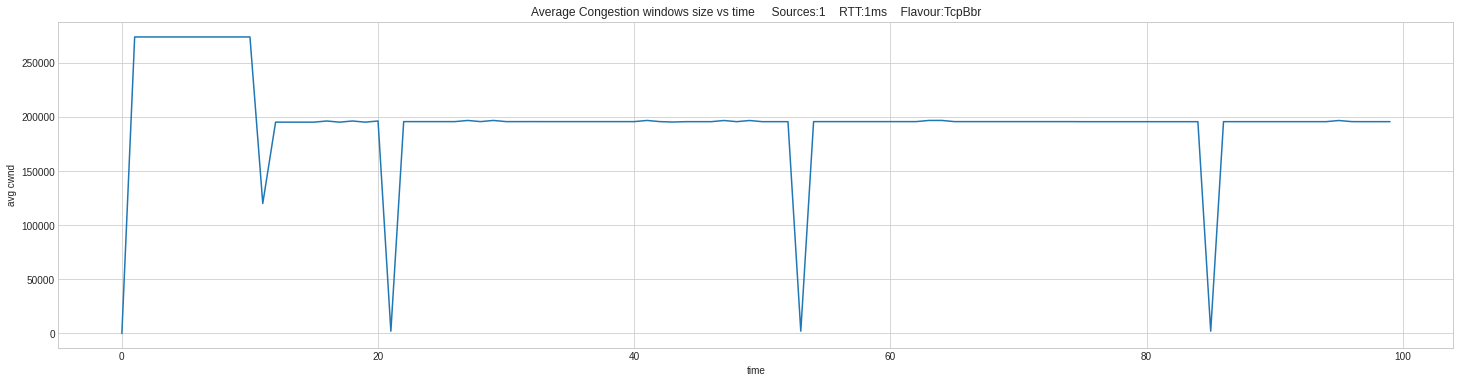

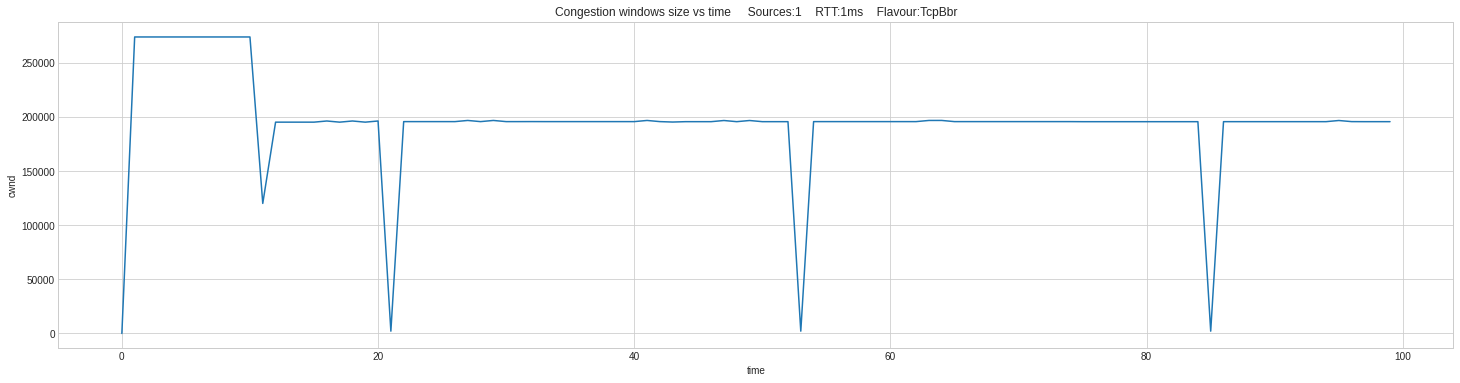

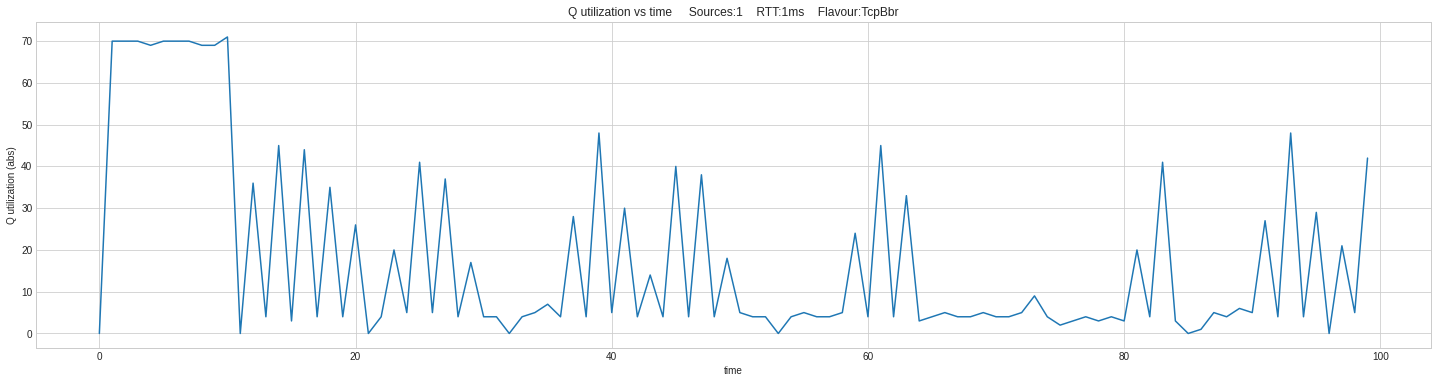

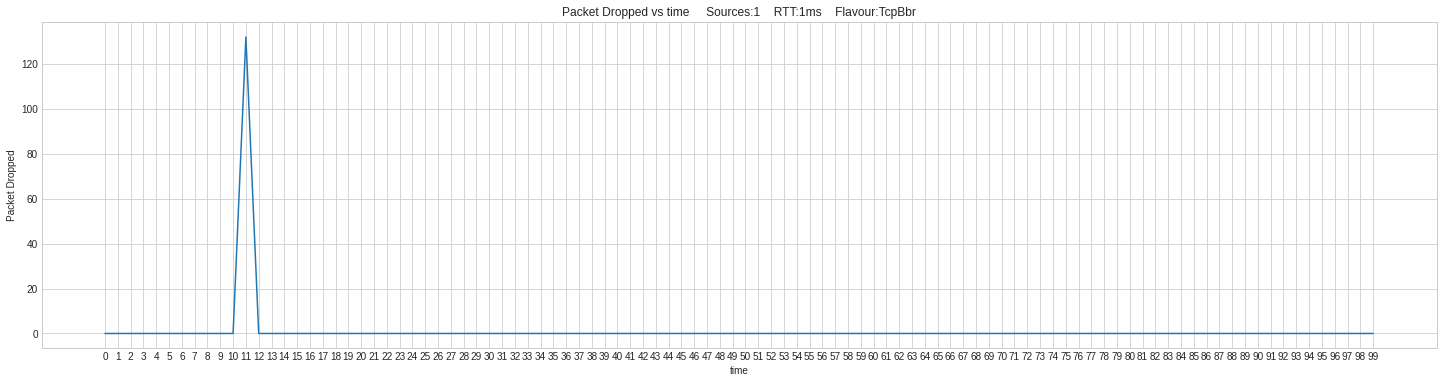

In [7]:
pktSize = 536

main(flavour = "TcpBbr", 
     time = 100, 
     noOfSource = 1, 
     total_access_bandwidth = "40Mbps", 
     RTT = "1ms",
     bottleneck_bandwidth = "10Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "1.5 BDP", 
     enableBottleneckTrace = 0,
     )

the maths of internet cong control - R shrikanth

2084p
[0/2] Re-checking globbed directories...
ninja: no work to do.
Process was interrupted by the user


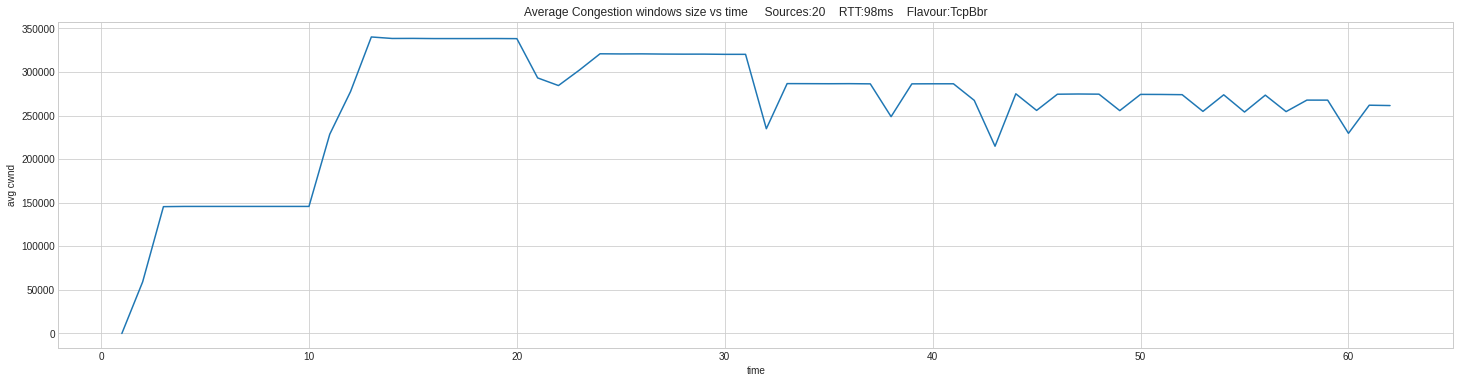

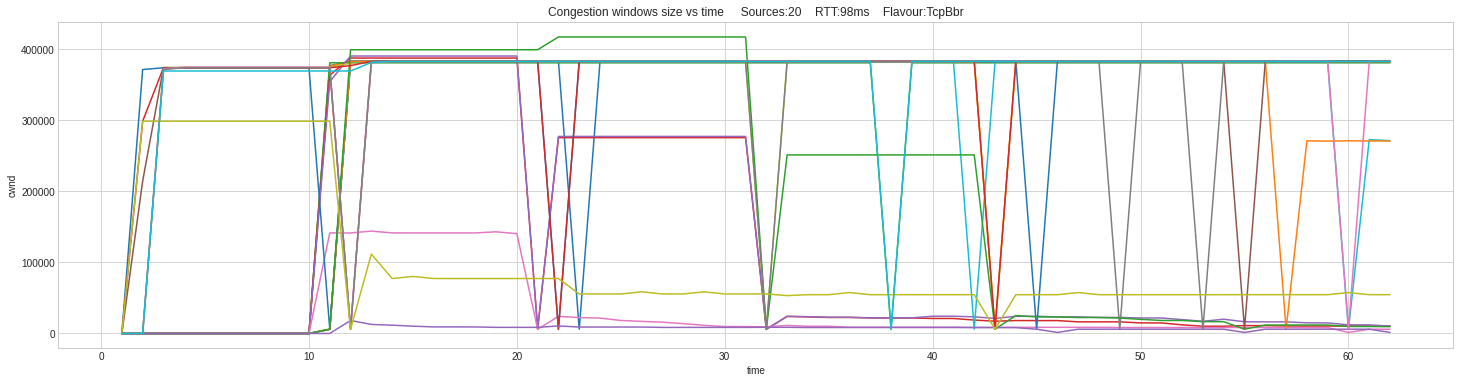

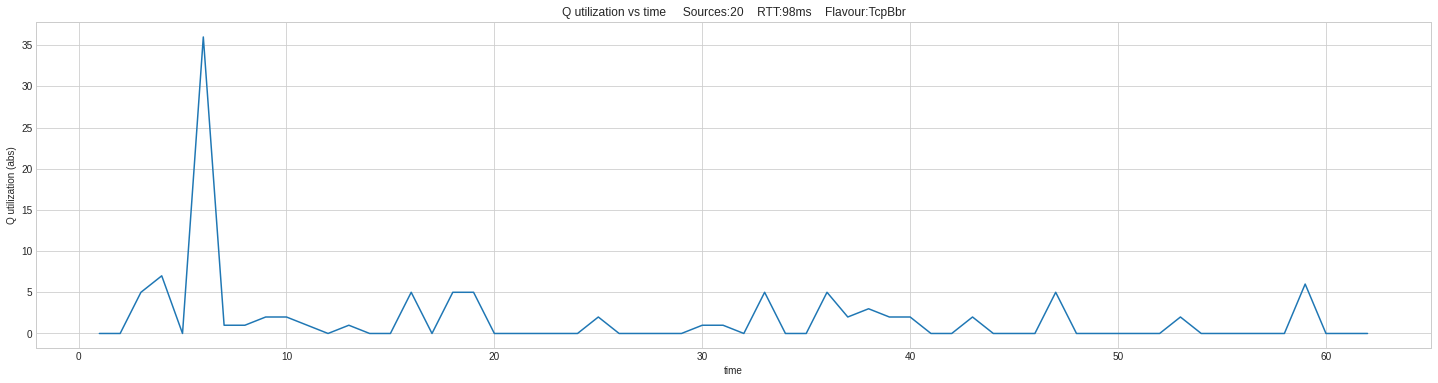

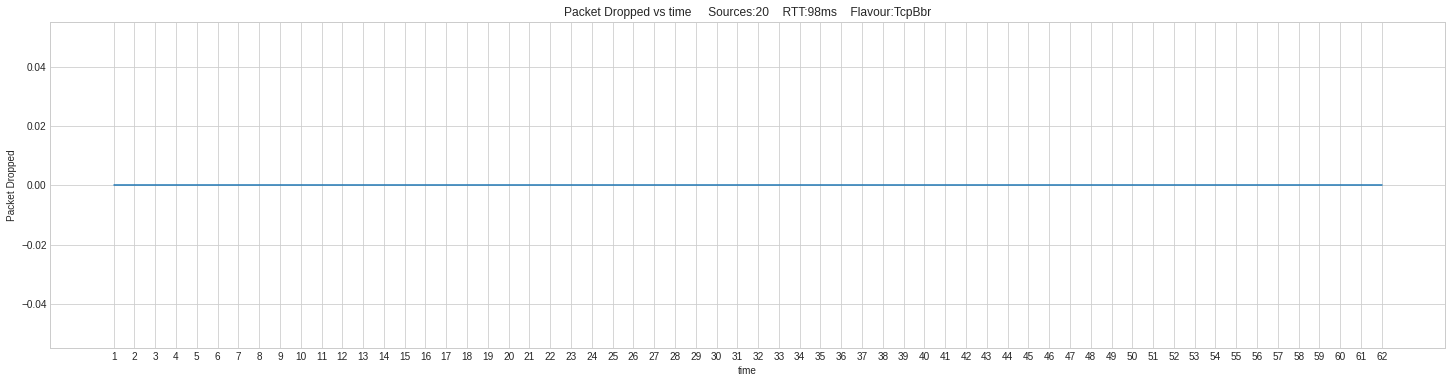

In [5]:
pktSize = 1500

main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 20, 
     total_access_bandwidth = "120Mbps", 
     RTT = "98ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     rcvBuff = str(pktSize*10000),
     sndBuff = str(pktSize*10000),
     SRBuffers = "off",
     enableBottleneckTrace = 0,
     )